https://colab.research.google.com/drive/1GkGLDexnYUnl2ilmwNxAlWAH6Eo5ZK2f?usp=sharing
https://towardsdatascience.com/cuda-by-numba-examples-215c0d285088

In [1]:
from time import perf_counter

import numpy as np

import numba
from numba import cuda

print(np.__version__)
print(numba.__version__)

cuda.detect()

1.24.1
0.58.0
Found 1 CUDA devices
id 0    b'NVIDIA GeForce RTX 3060 Laptop GPU'                              [SUPPORTED]
                      Compute Capability: 8.6
                           PCI Device ID: 0
                              PCI Bus ID: 1
                                    UUID: GPU-68a58ec2-b3d2-d27c-1c94-4dbdcb4b8ee0
                                Watchdog: Enabled
             FP32/FP64 Performance Ratio: 32
Summary:
	1/1 devices are supported


True

In [ ]:
#Simple Parallel Reduction Algorithm
def sum_cpu(array):
    s = 0.0
    for i in range(array.size):
        s += array[i]
    return s

In [3]:
threads_per_block = 1024  # Why not!
blocks_per_grid = 32 * 30  # Use 32 * multiple of streaming multiprocessors

# Example 2.1: Naive reduction
@cuda.jit
def reduce_naive(array, partial_reduction):
    i_start = cuda.grid(1)
    threads_per_grid = cuda.blockDim.x * cuda.gridDim.x
    s_thread = 0.0
    for i_arr in range(i_start, array.size, threads_per_grid):
        s_thread += array[i_arr]

    # We need to create a special *shared* array which will be able to be read
    # from and written to by every thread in the block. Each block will have its
    # own shared array. See the warning below!
    s_block = cuda.shared.array((threads_per_block,), numba.float32)
    
    # We now store the local temporary sum of a single the thread into the
    # shared array. Since the shared array is sized
    #     threads_per_block == blockDim.x
    # (1024 in this example), we should index it with `threadIdx.x`.
    tid = cuda.threadIdx.x
    s_block[tid] = s_thread
    
    # The next line synchronizes the threads in a block. It ensures that after
    # that line, all values have been written to `s_block`.
    cuda.syncthreads()

    # Finally, we need to sum the values from all threads to yield a single
    # value per block. We only need one thread for this.
    if tid == 0:
        # We store the sum of the elements of the shared array in its first
        # coordinate
        for i in range(1, threads_per_block):
            s_block[0] += s_block[i]
        # Move this partial sum to the output. Only one thread is writing here.
        partial_reduction[cuda.blockIdx.x] = s_block[0]

WARNING: The shared array must

*Be “small”.* The exact size depends on the compute capability of the GPU, typically between 48 KB and 163 KB. See item “Maximum amount of shared memory per thread block” in this table.
Have a known size at compile time (which is why we size our shared array threads_per_block and not blockDim.x). It is true that we can always define a factory function to shared array of any size... but be wary of compile time for these kernels.
Have dtype specified by Numba type, not a Numpy type (don't ask me why!).

In [4]:
N = 1_000_000_000
a = np.arange(N, dtype=np.float32)
a /= a.sum() # a will have sum = 1 (to float32 precision)

s_cpu = a.sum()

# Highly-optimized NumPy CPU code
timing_cpu = np.empty(21)
for i in range(timing_cpu.size):
    tic = perf_counter()
    a.sum()
    toc = perf_counter()
    timing_cpu[i] = toc - tic
timing_cpu *= 1e3  # convert to ms

print(f"Elapsed time CPU: {timing_cpu.mean():.0f} ± {timing_cpu.std():.0f} ms")
# Elapsed time CPU: 354 ± 24 ms

dev_a = cuda.to_device(a)
dev_partial_reduction = cuda.device_array((blocks_per_grid,), dtype=a.dtype)

reduce_naive[blocks_per_grid, threads_per_block](dev_a, dev_partial_reduction)
s = dev_partial_reduction.copy_to_host().sum()  # Final reduction in CPU

np.isclose(s, s_cpu)  # Ensure we have the right number
# True

timing_naive = np.empty(21)
for i in range(timing_naive.size):
    tic = perf_counter()
    reduce_naive[blocks_per_grid, threads_per_block](dev_a, dev_partial_reduction)
    s = dev_partial_reduction.copy_to_host().sum()
    cuda.synchronize()
    toc = perf_counter()
    assert np.isclose(s, s_cpu)    
    timing_naive[i] = toc - tic
timing_naive *= 1e3  # convert to ms

print(f"Elapsed time naive: {timing_naive.mean():.0f} ± {timing_naive.std():.0f} ms")
# Elapsed time naive: 30 ± 12 ms

Elapsed time CPU: 298 ± 32 ms
Elapsed time naive: 22 ± 1 ms


In [5]:
# Example 2.2: Better reduction
@cuda.jit
def reduce_better(array, partial_reduction):
    i_start = cuda.grid(1)
    threads_per_grid = cuda.blockDim.x * cuda.gridDim.x
    s_thread = 0.0
    for i_arr in range(i_start, array.size, threads_per_grid):
        s_thread += array[i_arr]

    # We need to create a special *shared* array which will be able to be read
    # from and written to by every thread in the block. Each block will have its
    # own shared array. See the warning below!
    s_block = cuda.shared.array((threads_per_block,), numba.float32)
    
    # We now store the local temporary sum of the thread into the shared array.
    # Since the shared array is sized threads_per_block == blockDim.x,
    # we should index it with `threadIdx.x`.
    tid = cuda.threadIdx.x
    s_block[tid] = s_thread
    
    # The next line synchronizes the threads in a block. It ensures that after
    # that line, all values have been written to `s_block`.
    cuda.syncthreads()

    i = cuda.blockDim.x // 2
    while (i > 0):
        if (tid < i):
            s_block[tid] += s_block[tid + i]
        cuda.syncthreads()
        i //= 2

    if tid == 0:
        partial_reduction[cuda.blockIdx.x] = s_block[0]


reduce_better[blocks_per_grid, threads_per_block](dev_a, dev_partial_reduction)
s = dev_partial_reduction.copy_to_host().sum()  # Final reduction in CPU

np.isclose(s, s_cpu)
# True

timing_naive = np.empty(21)
for i in range(timing_naive.size):
    tic = perf_counter()
    reduce_better[blocks_per_grid, threads_per_block](dev_a, dev_partial_reduction)
    s = dev_partial_reduction.copy_to_host().sum()
    cuda.synchronize()
    toc = perf_counter()
    assert np.isclose(s, s_cpu)    
    timing_naive[i] = toc - tic
timing_naive *= 1e3  # convert to ms

print(f"Elapsed time better: {timing_naive.mean():.0f} ± {timing_naive.std():.0f} ms")

Elapsed time better: 22 ± 2 ms


WARNING: You may be tempted to move syncthreads to inside the if block, since after every step, kernels beyond half of current number of threads will not be used. However, doing this will make CUDA threads which called syncthreads to stop and wait for all others, whereas all the other ones will just keep going. Consequently, the stopped threads will be forever waiting for threads that will never stop to synchronize. The takeaway is: if you synchronize threads, __ensure that cuda.syncthreads() is called in all threads.__

In [6]:
# Example 2.3: Numba reduction
@cuda.reduce
def reduce_numba(a, b):
    return a + b

# Compile and check
s = reduce_numba(dev_a)

np.isclose(s, s_cpu)
# True

# Time
timing_numba = np.empty(21)
for i in range(timing_numba.size):
    tic = perf_counter()
    s = reduce_numba(dev_a)
    toc = perf_counter()
    assert np.isclose(s, s_cpu)    
    timing_numba[i] = toc - tic
timing_numba *= 1e3  # convert to ms

print(f"Elapsed time better: {timing_numba.mean():.0f} ± {timing_numba.std():.0f} ms")

/usr/local/lib/python3.8/dist-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 64 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
/usr/local/lib/python3.8/dist-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 1 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


Elapsed time better: 15 ± 0 ms


In [7]:
#avoid host device copy
dev_s = cuda.device_array((1,), dtype=s)

reduce_numba(dev_a, res=dev_s)

s = dev_s.copy_to_host()[0]
np.isclose(s, s_cpu)

True

2D Reduction Example

In [8]:
#2D Reduction Example

threads_per_block_2d = (16, 16)  #  256 threads total
blocks_per_grid_2d = (64, 64)

# Total number of threads in a 2D block (has to be an int)
shared_array_len = int(np.prod(threads_per_block_2d))

# Example 2.4: 2D reduction with 1D shared array
@cuda.jit
def reduce2d(array2d, partial_reduction2d):
    ix, iy = cuda.grid(2)
    threads_per_grid_x, threads_per_grid_y = cuda.gridsize(2)

    s_thread = 0.0
    for i0 in range(iy, array2d.shape[0], threads_per_grid_x):
        for i1 in range(ix, array2d.shape[1], threads_per_grid_y):
            s_thread += array2d[i0, i1]

    # Allocate shared array
    s_block = cuda.shared.array(shared_array_len, numba.float32)

    # Index the threads linearly: each tid identifies a unique thread in the
    # 2D grid.
    tid = cuda.threadIdx.x + cuda.blockDim.x * cuda.threadIdx.y
    s_block[tid] = s_thread

    cuda.syncthreads()

    # We can use the same smart reduction algorithm by remembering that
    #     shared_array_len == blockDim.x * cuda.blockDim.y
    # So we just need to start our indexing accordingly.
    i = (cuda.blockDim.x * cuda.blockDim.y) // 2
    while (i != 0):
        if (tid < i):
            s_block[tid] += s_block[tid + i]
        cuda.syncthreads()
        i //= 2
    
    # Store reduction in a 2D array the same size as the 2D blocks
    if tid == 0:
        partial_reduction2d[cuda.blockIdx.x, cuda.blockIdx.y] = s_block[0]


N_2D = (20_000, 20_000)
a_2d = np.arange(np.prod(N_2D), dtype=np.float32).reshape(N_2D)
a_2d /= a_2d.sum() # a_2d will have sum = 1 (to float32 precision)

s_2d_cpu = a_2d.sum()

dev_a_2d = cuda.to_device(a_2d)
dev_partial_reduction_2d = cuda.device_array(blocks_per_grid_2d, dtype=a.dtype)

reduce2d[blocks_per_grid_2d, threads_per_block_2d](dev_a_2d, dev_partial_reduction_2d)
s_2d = dev_partial_reduction_2d.copy_to_host().sum()  # Final reduction in CPU

np.isclose(s_2d, s_2d_cpu)  # Ensure we have the right number
# True

timing_2d = np.empty(21)
for i in range(timing_2d.size):
    tic = perf_counter()
    reduce2d[blocks_per_grid_2d, threads_per_block_2d](dev_a_2d, dev_partial_reduction_2d)
    s_2d = dev_partial_reduction_2d.copy_to_host().sum()
    cuda.synchronize()
    toc = perf_counter()
    assert np.isclose(s_2d, s_2d_cpu)    
    timing_2d[i] = toc - tic
timing_2d *= 1e3  # convert to ms

print(f"Elapsed time better: {timing_2d.mean():.0f} ± {timing_2d.std():.0f} ms")

Elapsed time better: 296 ± 9 ms


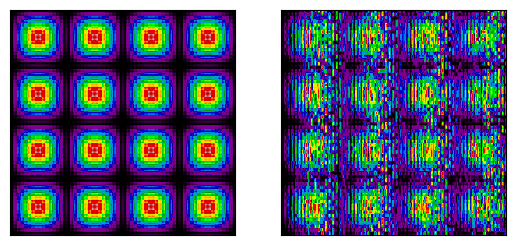

In [9]:
#Device functions
""" 
To end this part of the tutorial, we will show an example of using a device function 
across different kernels. The example will also stress how important it is to synchronize 
threads when using shared arrays.

INFO: In newer versions of CUDA, it is possible for kernels to launch other kernels. 
This is called dynamic parallelism and is not yet supported by Numba CUDA.
"""

threads_16 = 16

import math

@cuda.jit(device=True, inline=True)  # inlining can speed up execution
def amplitude(ix, iy):
    return (1 + math.sin(2 * math.pi * (ix - 64) / 256)) * (
        1 + math.sin(2 * math.pi * (iy - 64) / 256)
    )

# Example 2.5a: 2D Shared Array
@cuda.jit
def blobs_2d(array2d):
    ix, iy = cuda.grid(2)
    tix, tiy = cuda.threadIdx.x, cuda.threadIdx.y

    shared = cuda.shared.array((threads_16, threads_16), numba.float32)
    shared[tiy, tix] = amplitude(iy, ix)
    cuda.syncthreads()

    array2d[iy, ix] = shared[15 - tiy, 15 - tix]

# Example 2.5b: 2D Shared Array without synchronize
@cuda.jit
def blobs_2d_wrong(array2d):
    ix, iy = cuda.grid(2)
    tix, tiy = cuda.threadIdx.x, cuda.threadIdx.y

    shared = cuda.shared.array((threads_16, threads_16), numba.float32)
    shared[tiy, tix] = amplitude(iy, ix)

    # When we don't sync threads, we may have not written to shared
    # yet, or even have overwritten it by the time we write to array2d
    array2d[iy, ix] = shared[15 - tiy, 15 - tix]


N_img = 1024
blocks = (N_img // threads_16, N_img // threads_16)
threads = (threads_16, threads_16)

dev_image = cuda.device_array((N_img, N_img), dtype=np.float32)
dev_image_wrong = cuda.device_array((N_img, N_img), dtype=np.float32)

blobs_2d[blocks, threads](dev_image)
blobs_2d_wrong[blocks, threads](dev_image_wrong)

image = dev_image.copy_to_host()
image_wrong = dev_image_wrong.copy_to_host()

import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(image.T, cmap="nipy_spectral")
ax2.imshow(image_wrong.T, cmap="nipy_spectral")
for ax in (ax1, ax2):
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])